In [1]:
from gurgle.sp_gurgle import *
#from forged.drift import simple_shift_drift

In [2]:
import numpy as np


random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
dflt_stream = np.concatenate((dist_a, dist_b, dist_c))


def simple_shift_drift():
    """
    distribution with 2 shifts
    """
    return dflt_stream

In [3]:
import matplotlib.pyplot as plt

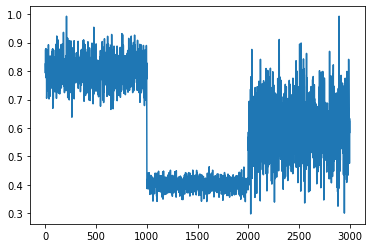

In [4]:
plt.plot(simple_shift_drift())

In [5]:
from matplotlib import gridspec
# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

Change detected at index 1055
Change detected at index 2079


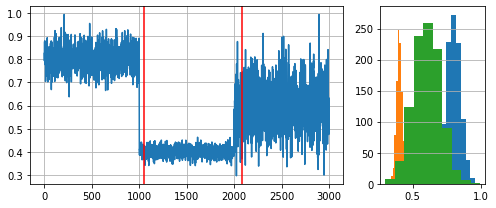

In [6]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []
stream = simple_shift_drift()
for i, val in enumerate(stream):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()   # As a best practice, we reset the detector

plot_data(dist_a, dist_b, dist_c, drifts)
# reverse the data: check the lag, do we want to refine the location 

In [7]:
from gurgle.base import enable_incremental_learning_on_call
from gurgle.sp_gurgle import *
from gurgle.sp_gurgle import GurgleWrap
from sklearn.preprocessing import MinMaxScaler


In [8]:
ndims = 3
normal = np.random.randint(0, 3, size=(1000, ndims))
abnormal = np.random.randint(10, 30, size=(1000, ndims))
normal_2 = np.random.randint(0, 3, size=(1000, ndims))
data = np.vstack((normal, abnormal, normal_2))
data[:3]

array([[2, 1, 1],
       [1, 2, 2],
       [0, 0, 1]])

In [9]:
# score will compute the distances to the eigenvalues of  the projector
gurgle = ResidueGurgle(projector=ScaledIncrementalPCA(n_components=2))

In [10]:
for i, row in enumerate(data):
    fv, score = gurgle(row)
    print(f"{i}: {row}: {fv=}, {score=}")

0: [2 1 1]: fv=None, score=None
1: [1 2 2]: fv=None, score=None
2: [0 0 1]: fv=None, score=None
3: [2 0 2]: fv=array([0.4330127 , 0.35355339]), score=array([0.74540904])
4: [2 2 0]: fv=array([-0.4330127 ,  2.47487373]), score=array([2.06050409])
5: [2 2 1]: fv=array([0.8660254 , 1.41421356]), score=array([-0.51800574])
6: [0 1 2]: fv=array([ 1.79418756, -0.06295915]), score=array([0.45468684])
7: [0 1 0]: fv=array([-0.37041419, -2.00751897]), score=array([2.21876855])
8: [0 1 1]: fv=array([ 0.71188668, -1.03523906]), score=array([0.70932533])
9: [0 2 2]: fv=array([1.14735551, 0.60060593]), score=array([-0.07530896])
10: [2 0 2]: fv=array([1.45745143, 0.07618665]), score=array([0.35119378])
11: [0 2 1]: fv=array([-0.15664267,  0.23095504]), score=array([0.04449887])
12: [2 0 2]: fv=array([ 1.49527087, -0.46926072]), score=array([0.33204747])
13: [1 1 2]: fv=array([1.04031708, 0.13908675]), score=array([-2.32013102])
14: [2 1 2]: fv=array([1.10035511, 0.60413344]), score=array([-1.233641

In [11]:
drift_detector = drift.ADWIN(delta=0.001)
drifts = []
scores = []
#stream = simple_shift_drift()
for i, row in enumerate(data):
    fv, score = gurgle(row)
    #if score is  None:
    #    continue
    #scores.append(score)
    drift_detector.update(score)   # Data is processed one sample at a time
    if drift_detector.change_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector.reset()   # As a best practice, we reset the detector

Change detected at index 1055
Change detected at index 1823


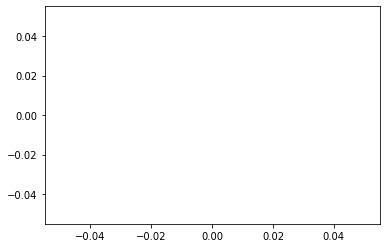

In [12]:
#plot_data(scores , drifts)
plt.plot(scores)


# Plot drifts detected

In [13]:
def plot_drifts(stream, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    ax= plt.subplot(1,1,1) 
    ax.plot(stream, label='Stream')
    
    if drifts is not None:
        for drift_detected in drifts:
            ax.axvline(drift_detected, color='red')
    plt.show()

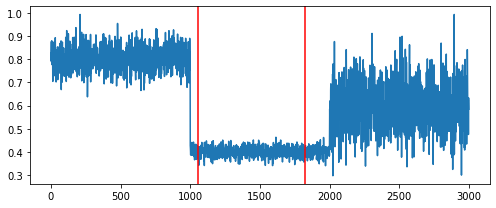

In [14]:
plot_drifts(stream, drifts)

# Add detector to gurgle

stream of data -> stream of drift-changes events 

In [15]:
def gurgle_score_stream(gurgle_instance, stream): # change order of params
    for i, row in enumerate(data):
        fv, score = gurgle_instance(row)
        yield score

In [16]:
scores = gurgle_score_stream(gurgle, data)
#list(scores)[:5]

In [31]:
def process_stream(score_stream, detector=drift.ADWIN):
    drift_detector = detector()
    for i, val in enumerate(stream):
        drift_detector.update(val)
        
        if drift_detector.change_detected:
            yield i
            drift_detector.reset()
        else:
            yield None
# blackify on click, or save!!! 

In [32]:
results = list(process_stream(scores))

In [33]:
results[:10]

[None, None, None, None, None, None, None, None, None, None]

In [34]:
drifts = [item for item in results if item is not None]
drifts

[1055, 2079]

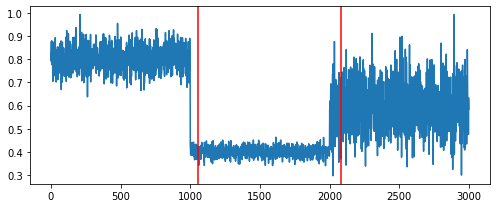

In [35]:
plot_drifts(stream, drifts)

# Using dags

In [36]:
from meshed import DAG
from meshed.dag import FuncNode

In [38]:


gurg = FuncNode(gurgle_score_stream, out='score_stream')
drifter = FuncNode(process_stream)

dag = DAG((gurg, drifter))

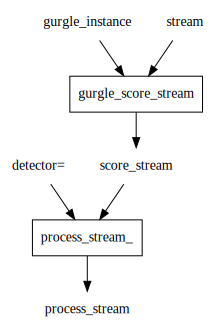

In [39]:
dag.dot_digraph()
